# データサイエンス100本ノック（構造化データ加工編） - Python (Google Colab環境)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/rootassist/100knocks-preprocess-inSQLandPython-withColab/blob/master/preprocess_knock_Python_Colab.ipynb)

## はじめに
- 初めに以下の「環境構築用のセル」を実行してください。(再開時にも実行する必要があります)
- 必要なライブラリのインポートとデータ読み込みを行います
  - ここでは、公式のリポジトリで提供されている解答に必要となるすべてのライブラリをインポートしています
  - データ（CSVファイル）はこのリポジトリからcurlコマンドで/tmp/data/100knock-preprocess/ディレクトリの下へ取得した上で読み込んでいます
  - CSVファイルの出力などは/tmp/dataに対して行います
- pandas等、利用が想定されるライブラリも以下の環境構築用のセルでインポートしています
- 解答にあたって、処理は複数回に分けても構いません
- 名前、住所等はダミーデータであり、実在するものではありません
- ノートは、Googleドライブの下のColab Notebooksフォルダの下に保存されます

In [2]:
#環境構築用のセル
!sudo mkdir -p /tmp/data/100knock-preprocess
!sudo chmod -R 777 /tmp/data

table_names = ('customer', 'category', 'product', 'receipt', 'store', 'geocode')
base = "/tmp/data/100knock-preprocess/"
baseurl = "https://raw.githubusercontent.com/rootassist/100knocks-preprocess-inSQLandPython-withColab/master/docker/work/data/"
for table_name in table_names:
   CURLCMD="curl -o "+base+table_name+".csv "+baseurl+table_name+".csv"
   !sudo $CURLCMD

!pip install --upgrade pip
!pip install -U pandas==1.5.3 numpy==1.23.5 scipy==1.11.2 scikit-learn==1.3.0 imbalanced-learn==0.11.0 numexpr==2.8.6

import os
import pandas as pd
import numpy as np
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import math
import psycopg2
from sqlalchemy import create_engine
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from imblearn.under_sampling import RandomUnderSampler

CSVPATH = '/tmp/data/100knock-preprocess'
df_customer =pd.read_csv(os.path.join(CSVPATH, 'customer.csv'), dtype={'customer_id': str, 'customer_name': str, 'gender_cd': str, 'gender': str, 'birth_day': np.int32, 'age': np.int32, 'postal_cd': str, 'address': str, 'application_store_cd': str, 'application_date': str, 'status_cd': str}, parse_dates=['birth_day'])
df_category = pd.read_csv(os.path.join(CSVPATH, 'category.csv'), dtype={'category_major_cd': str, 'category_major_name': str, 'category_medium_cd': str, 'category_medium_name': str, 'category_small_cd': str, 'category_small_name': str})
df_product = pd.read_csv(os.path.join(CSVPATH,'product.csv'), dtype={'product_cd': str, 'category_major_cd': str, 'category_medium_cd': str, 'category_small_cd': str, 'unit_price': np.float64, 'unit_cost': np.float64})
df_receipt = pd.read_csv(os.path.join(CSVPATH, 'receipt.csv'), dtype={'sales_ymd':np.int32, 'sales_epoch':np.int32, 'store_cd':str, 'receipt_no':np.int16, 'receipt_sub_no':np.int16, 'customer_id':str, 'product_cd':str, 'quantity':np.int32, 'amount':np.int32})
df_store = pd.read_csv(os.path.join(CSVPATH, 'store.csv'), dtype={'store_cd':str, 'store_name':str, 'prefecture_cd':str, 'prefecture':str, 'address':str, 'address_kana':str, 'tel_no':str, 'longitude':np.float64, 'latitude':np.float64, 'floor_area':np.float64})
df_geocode = pd.read_csv(os.path.join(CSVPATH, 'geocode.csv'), dtype={'postal_cd': str, 'prefecture': str, 'city': str, 'town': str, 'street': str, 'address': str, 'full_address': str, 'longitude': np.float64, 'latitude': np.float64})

%cd /tmp

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2825k  100 2825k    0     0  14.6M      0 --:--:-- --:--:-- --:--:-- 14.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12882  100 12882    0     0   116k      0 --:--:-- --:--:-- --:--:--  117k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341k  100  341k    0     0  2297k      0 --:--:-- --:--:-- --:--:-- 2305k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6726k  100 6726k    0     0  31.4M      0 --:--:-- --:--:-- --:--:-- 31.4M
  % Total    % Received % Xferd  Average Speed   Tim

# 演習問題

---
> P-001: レシート明細データ（df_receipt）から全項目の先頭10件を表示し、どのようなデータを保有しているか目視で確認せよ。

---
> P-002: レシート明細データ（df_receipt）から売上年月日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、10件表示せよ。

---
> P-003: レシート明細データ（df_receipt）から売上年月日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、10件表示せよ。ただし、sales_ymdをsales_dateに項目名を変更しながら抽出すること。

---
> P-004: レシート明細データ（df_receipt）から売上日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、以下の条件を満たすデータを抽出せよ。
> - 顧客ID（customer_id）が"CS018205000001"

---
> P-005: レシート明細データ（df_receipt）から売上日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、以下の全ての条件を満たすデータを抽出せよ。
> - 顧客ID（customer_id）が"CS018205000001"
> - 売上金額（amount）が1,000以上

---
> P-006: レシート明細データ（df_receipt）から売上日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上数量（quantity）、売上金額（amount）の順に列を指定し、以下の全ての条件を満たすデータを抽出せよ。
> - 顧客ID（customer_id）が"CS018205000001"
> - 売上金額（amount）が1,000以上または売上数量（quantity）が5以上

---
> P-007: レシート明細データ（df_receipt）から売上日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、以下の全ての条件を満たすデータを抽出せよ。
> - 顧客ID（customer_id）が"CS018205000001"
> - 売上金額（amount）が1,000以上2,000以下

---
> P-008: レシート明細データ（df_receipt）から売上日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、以下の全ての条件を満たすデータを抽出せよ。
> - 顧客ID（customer_id）が"CS018205000001"
> - 商品コード（product_cd）が"P071401019"以外

---
> P-009: 以下の処理において、出力結果を変えずにORをANDに書き換えよ。
>
> `df_store.query('not(prefecture_cd == "13" | floor_area > 900)')`

---
> P-010: 店舗データ（df_store）から、店舗コード（store_cd）が"S14"で始まるものだけ全項目抽出し、10件表示せよ。

---
> P-011: 顧客データ（df_customer）から顧客ID（customer_id）の末尾が1のものだけ全項目抽出し、10件表示せよ。

---
> P-012: 店舗データ（df_store）から、住所 (address) に"横浜市"が含まれるものだけ全項目表示せよ。

---
> P-013: 顧客データ（df_customer）から、ステータスコード（status_cd）の先頭がアルファベットのA〜Fで始まるデータを全項目抽出し、10件表示せよ。

---
> P-014: 顧客データ（df_customer）から、ステータスコード（status_cd）の末尾が数字の1〜9で終わるデータを全項目抽出し、10件表示せよ。

---
> P-015: 顧客データ（df_customer）から、ステータスコード（status_cd）の先頭がアルファベットのA〜Fで始まり、末尾が数字の1〜9で終わるデータを全項目抽出し、10件表示せよ。

---
> P-016: 店舗データ（df_store）から、電話番号（tel_no）が3桁-3桁-4桁のデータを全項目表示せよ。

---
> P-017: 顧客データ（df_customer）を生年月日（birth_day）で高齢順にソートし、先頭から全項目を10件表示せよ。

---
> P-018: 顧客データ（df_customer）を生年月日（birth_day）で若い順にソートし、先頭から全項目を10件表示せよ。

---
> P-019: レシート明細データ（df_receipt）に対し、1件あたりの売上金額（amount）が高い順にランクを付与し、先頭から10件表示せよ。項目は顧客ID（customer_id）、売上金額（amount）、付与したランクを表示させること。なお、売上金額（amount）が等しい場合は同一順位を付与するものとする。

---
> P-020: レシート明細データ（df_receipt）に対し、1件あたりの売上金額（amount）が高い順にランクを付与し、先頭から10件表示せよ。項目は顧客ID（customer_id）、売上金額（amount）、付与したランクを表示させること。なお、売上金額（amount）が等しい場合でも別順位を付与すること。

---
> P-021: レシート明細データ（df_receipt）に対し、件数をカウントせよ。

---
> P-022: レシート明細データ（df_receipt）の顧客ID（customer_id）に対し、ユニーク件数をカウントせよ。

---
> P-023: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）と売上数量（quantity）を合計せよ。

---
> P-024: レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに最も新しい売上年月日（sales_ymd）を求め、10件表示せよ。

---
> P-025: レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに最も古い売上年月日（sales_ymd）を求め、10件表示せよ。

---
> P-026: レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに最も新しい売上年月日（sales_ymd）と古い売上年月日を求め、両者が異なるデータを10件表示せよ。

---
> P-027: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の平均を計算し、降順でTOP5を表示せよ。

---
> P-028: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の中央値を計算し、降順でTOP5を表示せよ。

---
> P-029: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに商品コード（product_cd）の最頻値を求め、10件表示させよ。

---
> P-030: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の分散を計算し、降順で5件表示せよ。

---
> P-031: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の標準偏差を計算し、降順で5件表示せよ。

TIPS:

PandasとNumpyでddofのデフォルト値が異なることに注意しましょう
```
Pandas：
DataFrame.std(self, axis=None, skipna=None, level=None, ddof=1, numeric_only=None, **kwargs)
Numpy:
numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=)
```

---
> P-032: レシート明細データ（df_receipt）の売上金額（amount）について、25％刻みでパーセンタイル値を求めよ。

---
> P-033: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の平均を計算し、330以上のものを抽出せよ。

---
> P-034: レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに売上金額（amount）を合計して全顧客の平均を求めよ。ただし、顧客IDが"Z"から始まるものは非会員を表すため、除外して計算すること。

---
> P-035: レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに売上金額（amount）を合計して全顧客の平均を求め、平均以上に買い物をしている顧客を抽出し、10件表示せよ。ただし、顧客IDが"Z"から始まるものは非会員を表すため、除外して計算すること。

---
> P-036: レシート明細データ（df_receipt）と店舗データ（df_store）を内部結合し、レシート明細データの全項目と店舗データの店舗名（store_name）を10件表示せよ。

---
> P-037: 商品データ（df_product）とカテゴリデータ（df_category）を内部結合し、商品データの全項目とカテゴリデータのカテゴリ小区分名（category_small_name）を10件表示せよ。

---
> P-038: 顧客データ（df_customer）とレシート明細データ（df_receipt）から、顧客ごとの売上金額合計を求め、10件表示せよ。ただし、売上実績がない顧客については売上金額を0として表示させること。また、顧客は性別コード（gender_cd）が女性（1）であるものを対象とし、非会員（顧客IDが"Z"から始まるもの）は除外すること。

---
> P-039: レシート明細データ（df_receipt）から、売上日数の多い顧客の上位20件を抽出したデータと、売上金額合計の多い顧客の上位20件を抽出したデータをそれぞれ作成し、さらにその2つを完全外部結合せよ。ただし、非会員（顧客IDが"Z"から始まるもの）は除外すること。

---
> P-040: 全ての店舗と全ての商品を組み合わせたデータを作成したい。店舗データ（df_store）と商品データ（df_product）を直積し、件数を計算せよ。

---
> P-041: レシート明細データ（df_receipt）の売上金額（amount）を日付（sales_ymd）ごとに集計し、前回売上があった日からの売上金額増減を計算せよ。そして結果を10件表示せよ。

---
> P-042: レシート明細データ（df_receipt）の売上金額（amount）を日付（sales_ymd）ごとに集計し、各日付のデータに対し、前回、前々回、3回前に売上があった日のデータを結合せよ。そして結果を10件表示せよ。

---
> P-043： レシート明細データ（df_receipt）と顧客データ（df_customer）を結合し、性別コード（gender_cd）と年代（ageから計算）ごとに売上金額（amount）を合計した売上サマリデータを作成せよ。性別コードは0が男性、1が女性、9が不明を表すものとする。
>
> ただし、項目構成は年代、女性の売上金額、男性の売上金額、性別不明の売上金額の4項目とすること（縦に年代、横に性別のクロス集計）。また、年代は10歳ごとの階級とすること。

In [22]:
# df のマージ
df_receipt_customer = pd.merge(df_receipt, df_customer,
                               how="inner",
                               on="customer_id")
# 年代列の作成
df_receipt_customer["era"] = df_receipt_customer["age"].apply(lambda x: math.floor(x / 10) * 10)
# 年代かつ性別毎の売上合計データを作成
df_summary_of_era_gender = pd.pivot_table(
    df_receipt_customer,
    index="era",
    columns = "gender_cd",
    values="amount",
    aggfunc="sum"
).reset_index()
df_summary_of_era_gender = df_summary_of_era_gender.rename({"0":"male", "1":"female", "9":"unkonwn"}, axis=1).copy()
df_summary_of_era_gender

gender_cd,era,male,female,unkonwn
0,10,1591.0,149836.0,4317.0
1,20,72940.0,1363724.0,44328.0
2,30,177322.0,693047.0,50441.0
3,40,19355.0,9320791.0,483512.0
4,50,54320.0,6685192.0,342923.0
5,60,272469.0,987741.0,71418.0
6,70,13435.0,29764.0,2427.0
7,80,46360.0,262923.0,5111.0
8,90,NaN,6260.0,NaN


Text(0.5, 0, 'era')

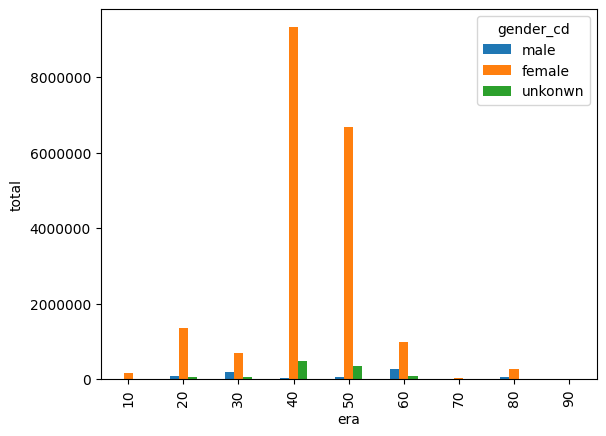

In [26]:
import matplotlib.pyplot as plt
df_summary_of_era_gender.plot(kind="bar",
                              x = "era")
plt.ticklabel_format(style="plain", axis="y")
plt.ylabel("total")
plt.xlabel("era")

In [32]:
df_receipt_customer.groupby("gender_cd").agg(
    gender_cd_count = ("gender_cd", "count"),
    gender_cd_name = ("gender", "unique")
    )

,gender_cd_count,gender_cd_name
gender_cd,,
0,2028,[男性]
1,60480,[女性]
9,3174,[不明]


In [78]:
df_tmp = pd.merge(df_receipt,
                  df_customer,
                  how="inner",
                  on="customer_id")
df_tmp["era"] = df_tmp["age"].apply(lambda x: math.floor(x / 10) * 10)
df_sales_sammary = pd.pivot_table(
    df_tmp,
    index = "era",
    columns = "gender_cd",
    values = "amount",
    aggfunc = "sum"
    ).reset_index()
df_sales_sammary.columns = ["era", "male", "female", "unknown"]
df_sales_sammary


,era,male,female,unknown
0,10,1591.0,149836.0,4317.0
1,20,72940.0,1363724.0,44328.0
2,30,177322.0,693047.0,50441.0
3,40,19355.0,9320791.0,483512.0
4,50,54320.0,6685192.0,342923.0
5,60,272469.0,987741.0,71418.0
6,70,13435.0,29764.0,2427.0
7,80,46360.0,262923.0,5111.0
8,90,NaN,6260.0,NaN


---
> P-044： 043で作成した売上サマリデータ（df_sales_summary）は性別の売上を横持ちさせたものであった。このデータから性別を縦持ちさせ、年代、性別コード、売上金額の3項目に変換せよ。ただし、性別コードは男性を"00"、女性を"01"、不明を"99"とする。
>
>> **※ Colaboratoryで演習を再開したときは、解答前にP-043の解答を実行して下さい**

In [85]:
# ある列の要素名変更: .replace()
# 列名変更: .rename()
# この問題の意図は性別コードをreplaceすることである。しかし解答は、df全体がreplace()対象になっている。
# 性別コードのみ対象にして.replace()を適用する。
df_sales_sammary_unstacked = df_sales_sammary.set_index("era").stack().reset_index().rename({"level_1": "gender_cd", 0: "amount"}, axis=1)
df_sales_sammary_unstacked
df_sales_sammary_unstacked["gender_cd"] = df_sales_sammary_unstacked["gender_cd"].replace({"male": "00", "female": "01", "unknown":"99"}).copy()
df_sales_sammary_unstacked

,era,gender_cd,amount
0,10,00,1591.0
1,10,01,149836.0
2,10,99,4317.0
3,20,00,72940.0
4,20,01,1363724.0
5,20,99,44328.0
6,30,00,177322.0
7,30,01,693047.0
8,30,99,50441.0
9,40,00,19355.0


---
> P-045: 顧客データ（df_customer）の生年月日（birth_day）は日付型でデータを保有している。これをYYYYMMDD形式の文字列に変換し、顧客ID（customer_id）とともに10件表示せよ。

In [91]:
# df_customer.info()
pd.concat([df_customer["customer_id"],
           # 確実にdatetime型に対して操作するようにしている。既に変換されていたら処理速度面から見ても不要。
        #   pd.to_datetime(df_customer["birth_day"]).dt.strftime("%Y%m%d")], axis=1).head()
          df_customer["birth_day"].dt.strftime("%Y%m%d")], axis=1).head()

,customer_id,birth_day
0,CS021313000114,19810429
1,CS037613000071,19520401
2,CS031415000172,19761004
3,CS028811000001,19330327
4,CS001215000145,19950329


---
> P-046: 顧客データ（df_customer）の申し込み日（application_date）はYYYYMMDD形式の文字列型でデータを保有している。これを日付型に変換し、顧客ID（customer_id）とともに10件表示せよ。

---
> P-047: レシート明細データ（df_receipt）の売上日（sales_ymd）はYYYYMMDD形式の数値型でデータを保有している。これを日付型に変換し、レシート番号（receipt_no）、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。

---
> P-048: レシート明細データ（df_receipt）の売上エポック秒（sales_epoch）は数値型のUNIX秒でデータを保有している。これを日付型に変換し、レシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。

---
> P-049: レシート明細データ（df_receipt）の売上エポック秒（sales_epoch）を日付型に変換し、「年」だけ取り出してレシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。

---
> P-050: レシート明細データ（df_receipt）の売上エポック秒（sales_epoch）を日付型に変換し、「月」だけ取り出してレシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。なお、「月」は0埋め2桁で取り出すこと。

---
> P-051: レシート明細データ（df_receipt）の売上エポック秒を日付型に変換し、「日」だけ取り出してレシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。なお、「日」は0埋め2桁で取り出すこと。

---
> P-052: レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計の上、売上金額合計に対して2,000円以下を0、2,000円より大きい金額を1に二値化し、顧客ID、売上金額合計とともに10件表示せよ。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

---
> P-053: 顧客データ（df_customer）の郵便番号（postal_cd）に対し、東京（先頭3桁が100〜209のもの）を1、それ以外のものを0に二値化せよ。さらにレシート明細データ（df_receipt）と結合し、全期間において売上実績のある顧客数を、作成した二値ごとにカウントせよ。

---
> P-054: 顧客データ（df_customer）の住所（address）は、埼玉県、千葉県、東京都、神奈川県のいずれかとなっている。都道府県毎にコード値を作成し、顧客ID、住所とともに10件表示せよ。値は埼玉県を11、千葉県を12、東京都を13、神奈川県を14とすること。

---
> P-055: レシート明細（df_receipt）データの売上金額（amount）を顧客ID（customer_id）ごとに合計し、その合計金額の四分位点を求めよ。その上で、顧客ごとの売上金額合計に対して以下の基準でカテゴリ値を作成し、顧客ID、売上金額合計とともに10件表示せよ。カテゴリ値は順に1〜4とする。
>
> - 最小値以上第1四分位未満 ・・・ 1を付与
> - 第1四分位以上第2四分位未満 ・・・ 2を付与
> - 第2四分位以上第3四分位未満 ・・・ 3を付与
> - 第3四分位以上 ・・・ 4を付与

---
> P-056: 顧客データ（df_customer）の年齢（age）をもとに10歳刻みで年代を算出し、顧客ID（customer_id）、生年月日（birth_day）とともに10件表示せよ。ただし、60歳以上は全て60歳代とすること。年代を表すカテゴリ名は任意とする。

---
> P-057: 056の抽出結果と性別コード（gender_cd）により、新たに性別×年代の組み合わせを表すカテゴリデータを作成し、10件表示せよ。組み合わせを表すカテゴリの値は任意とする。

---
> P-058: 顧客データ（df_customer）の性別コード（gender_cd）をダミー変数化し、顧客ID（customer_id）とともに10件表示せよ。

---
> P-059: レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計し、売上金額合計を平均0、標準偏差1に標準化して顧客ID、売上金額合計とともに10件表示せよ。標準化に使用する標準偏差は、分散の平方根、もしくは不偏分散の平方根のどちらでも良いものとする。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

TIPS:
- query()の引数engineで'python'か'numexpr'かを選択でき、デフォルトはインストールされていればnumexprが、無ければpythonが使われます。さらに、文字列メソッドはengine='python'でないとquery()内で使えません。


---
> P-060: レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計し、売上金額合計を最小値0、最大値1に正規化して顧客ID、売上金額合計とともに10件表示せよ。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

---
> P-061: レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計し、売上金額合計を常用対数化（底10）して顧客ID、売上金額合計とともに10件表示せよ。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

---
> P-062: レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計し、売上金額合計を自然対数化（底e）して顧客ID、売上金額合計とともに10件表示せよ。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

---
> P-063: 商品データ（df_product）の単価（unit_price）と原価（unit_cost）から各商品の利益額を算出し、結果を10件表示せよ。

---
> P-064: 商品データ（df_product）の単価（unit_price）と原価（unit_cost）から、各商品の利益率の全体平均を算出せよ。ただし、単価と原価には欠損が生じていることに注意せよ。

---
> P-065: 商品データ（df_product）の各商品について、利益率が30%となる新たな単価を求めよ。ただし、1円未満は切り捨てること。そして結果を10件表示させ、利益率がおよそ30％付近であることを確認せよ。ただし、単価（unit_price）と原価（unit_cost）には欠損が生じていることに注意せよ。

---
> P-066: 商品データ（df_product）の各商品について、利益率が30%となる新たな単価を求めよ。今回は、1円未満を丸めること（四捨五入または偶数への丸めで良い）。そして結果を10件表示させ、利益率がおよそ30％付近であることを確認せよ。ただし、単価（unit_price）と原価（unit_cost）には欠損が生じていることに注意せよ。

---
> P-067: 商品データ（df_product）の各商品について、利益率が30%となる新たな単価を求めよ。今回は、1円未満を切り上げること。そして結果を10件表示させ、利益率がおよそ30％付近であることを確認せよ。ただし、単価（unit_price）と原価（unit_cost）には欠損が生じていることに注意せよ。

---
> P-068: 商品データ（df_product）の各商品について、消費税率10％の税込み金額を求めよ。1円未満の端数は切り捨てとし、結果を10件表示せよ。ただし、単価（unit_price）には欠損が生じていることに注意せよ。

---
> P-069: レシート明細データ（df_receipt）と商品データ（df_product）を結合し、顧客毎に全商品の売上金額合計と、カテゴリ大区分コード（category_major_cd）が"07"（瓶詰缶詰）の売上金額合計を計算の上、両者の比率を求めよ。抽出対象はカテゴリ大区分コード"07"（瓶詰缶詰）の売上実績がある顧客のみとし、結果を10件表示せよ。

---
> P-070: レシート明細データ（df_receipt）の売上日（sales_ymd）に対し、顧客データ（df_customer）の会員申込日（application_date）からの経過日数を計算し、顧客ID（customer_id）、売上日、会員申込日とともに10件表示せよ（sales_ymdは数値、application_dateは文字列でデータを保持している点に注意）。

---
> P-071: レシート明細データ（df_receipt）の売上日（sales_ymd）に対し、顧客データ（df_customer）の会員申込日（application_date）からの経過月数を計算し、顧客ID（customer_id）、売上日、会員申込日とともに10件表示せよ（sales_ymdは数値、application_dateは文字列でデータを保持している点に注意）。1ヶ月未満は切り捨てること。

---
> P-072: レシート明細データ（df_receipt）の売上日（df_customer）に対し、顧客データ（df_customer）の会員申込日（application_date）からの経過年数を計算し、顧客ID（customer_id）、売上日、会員申込日とともに10件表示せよ（sales_ymdは数値、application_dateは文字列でデータを保持している点に注意）。1年未満は切り捨てること。

---
> P-073: レシート明細データ（df_receipt）の売上日（sales_ymd）に対し、顧客データ（df_customer）の会員申込日（application_date）からのエポック秒による経過時間を計算し、顧客ID（customer_id）、売上日、会員申込日とともに10件表示せよ（なお、sales_ymdは数値、application_dateは文字列でデータを保持している点に注意）。なお、時間情報は保有していないため各日付は0時0分0秒を表すものとする。

---
> P-074: レシート明細データ（df_receipt）の売上日（sales_ymd）に対し、当該週の月曜日からの経過日数を計算し、売上日、直前の月曜日付とともに10件表示せよ（sales_ymdは数値でデータを保持している点に注意）。

---
> P-075: 顧客データ（df_customer）からランダムに1%のデータを抽出し、先頭から10件表示せよ。

---
> P-076: 顧客データ（df_customer）から性別コード（gender_cd）の割合に基づきランダムに10%のデータを層化抽出し、性別コードごとに件数を集計せよ。

---
> P-077: レシート明細データ（df_receipt）の売上金額を顧客単位に合計し、合計した売上金額の外れ値を抽出せよ。なお、外れ値は売上金額合計を対数化したうえで平均と標準偏差を計算し、その平均から3σを超えて離れたものとする（自然対数と常用対数のどちらでも可）。結果は10件表示せよ。

---
> P-078: レシート明細データ（df_receipt）の売上金額（amount）を顧客単位に合計し、合計した売上金額の外れ値を抽出せよ。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。なお、ここでは外れ値を第1四分位と第3四分位の差であるIQRを用いて、「第1四分位数-1.5×IQR」を下回るもの、または「第3四分位数+1.5×IQR」を超えるものとする。結果は10件表示せよ。

---
> P-079: 商品データ（df_product）の各項目に対し、欠損数を確認せよ。

---
> P-080: 商品データ（df_product）のいずれかの項目に欠損が発生しているレコードを全て削除した新たな商品データを作成せよ。なお、削除前後の件数を表示させ、079で確認した件数だけ減少していることも確認すること。

---
> P-081: 単価（unit_price）と原価（unit_cost）の欠損値について、それぞれの平均値で補完した新たな商品データを作成せよ。なお、平均値については1円未満を丸めること（四捨五入または偶数への丸めで良い）。補完実施後、各項目について欠損が生じていないことも確認すること。

---
> P-082: 単価（unit_price）と原価（unit_cost）の欠損値について、それぞれの中央値で補完した新たな商品データを作成せよ。なお、中央値については1円未満を丸めること（四捨五入または偶数への丸めで良い）。補完実施後、各項目について欠損が生じていないことも確認すること。

---
> P-083: 単価（unit_price）と原価（unit_cost）の欠損値について、各商品のカテゴリ小区分コード（category_small_cd）ごとに算出した中央値で補完した新たな商品データを作成せよ。なお、中央値については1円未満を丸めること（四捨五入または偶数への丸めで良い）。補完実施後、各項目について欠損が生じていないことも確認すること。

---
> P-084: 顧客データ（df_customer）の全顧客に対して全期間の売上金額に占める2019年売上金額の割合を計算し、新たなデータを作成せよ。ただし、売上実績がない場合は0として扱うこと。そして計算した割合が0超のものを抽出し、結果を10件表示せよ。また、作成したデータに欠損が存在しないことを確認せよ。

---
> P-085: 顧客データ（df_customer）の全顧客に対し、郵便番号（postal_cd）を用いてジオコードデータ（df_geocode）を紐付け、新たな顧客データを作成せよ。ただし、1つの郵便番号（postal_cd）に複数の経度（longitude）、緯度（latitude）情報が紐づく場合は、経度（longitude）、緯度（latitude）の平均値を算出して使用すること。また、作成結果を確認するために結果を10件表示せよ。

---
> P-086: 085で作成した緯度経度つき顧客データに対し、会員申込店舗コード（application_store_cd）をキーに店舗データ（df_store）と結合せよ。そして申込み店舗の緯度（latitude）・経度情報（longitude)と顧客住所（address）の緯度・経度を用いて申込み店舗と顧客住所の距離（単位：km）を求め、顧客ID（customer_id）、顧客住所（address）、店舗住所（address）とともに表示せよ。計算式は以下の簡易式で良いものとするが、その他精度の高い方式を利用したライブラリを利用してもかまわない。結果は10件表示せよ。
>
>> **※ Colaboratoryで演習を再開したときは、解答前にP-085の解答を実行して下さい**
$$
緯度（ラジアン）：\phi \\
経度（ラジアン）：\lambda \\
距離L = 6371 * arccos(sin \phi_1 * sin \phi_2
+ cos \phi_1 * cos \phi_2 * cos(\lambda_1 − \lambda_2))
$$

---
> P-087: 顧客データ（df_customer）では、異なる店舗での申込みなどにより同一顧客が複数登録されている。名前（customer_name）と郵便番号（postal_cd）が同じ顧客は同一顧客とみなして1顧客1レコードとなるように名寄せした名寄顧客データを作成し、顧客データの件数、名寄顧客データの件数、重複数を算出せよ。ただし、同一顧客に対しては売上金額合計が最も高いものを残し、売上金額合計が同一もしくは売上実績がない顧客については顧客ID（customer_id）の番号が小さいものを残すこととする。

---
> P-088: 087で作成したデータを元に、顧客データに統合名寄IDを付与したデータを作成せよ。ただし、統合名寄IDは以下の仕様で付与するものとする。
>
> - 重複していない顧客：顧客ID（customer_id）を設定
> - 重複している顧客：前設問で抽出したレコードの顧客IDを設定
>
> 顧客IDのユニーク件数と、統合名寄IDのユニーク件数の差も確認すること。
>
>> **※ Colaboratoryで演習を再開したときは、解答前にP-087の解答を実行して下さい**

---
> P-089: 売上実績がある顧客を、予測モデル構築のため学習用データとテスト用データに分割したい。それぞれ8:2の割合でランダムにデータを分割せよ。

---
> P-090: レシート明細データ（df_receipt）は2017年1月1日〜2019年10月31日までのデータを有している。売上金額（amount）を月次で集計し、学習用に12ヶ月、テスト用に6ヶ月の時系列モデル構築用データを3セット作成せよ。

---
> P-091: 顧客データ（df_customer）の各顧客に対し、売上実績がある顧客数と売上実績がない顧客数が1:1となるようにアンダーサンプリングで抽出せよ。

---
> P-092: 顧客データ（df_customer）の性別について、第三正規形へと正規化せよ。

---
> P-093: 商品データ（df_product）では各カテゴリのコード値だけを保有し、カテゴリ名は保有していない。カテゴリデータ（df_category）と組み合わせて非正規化し、カテゴリ名を保有した新たな商品データを作成せよ。

---
> P-094: 093で作成したカテゴリ名付き商品データを以下の仕様でファイル出力せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |CSV（カンマ区切り）|有り|UTF-8|
>
> ファイル出力先のパスは以下のようにすること
>
> |出力先|
> |:--:|
> |./data|
>
>> **※ Colaboratoryで演習を再開したときは、解答前にP-093の解答を実行して下さい**

---
> P-095: 093で作成したカテゴリ名付き商品データを以下の仕様でファイル出力せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |CSV（カンマ区切り）|有り|CP932|
>
> ファイル出力先のパスは以下のようにすること。
>
> |出力先|
> |:--:|
> |./data|
>
>> **※ Colaboratoryで演習を再開したときは、解答前にP-093の解答を実行して下さい**

---
> P-096: 093で作成したカテゴリ名付き商品データを以下の仕様でファイル出力せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |CSV（カンマ区切り）|無し|UTF-8|
>
> ファイル出力先のパスは以下のようにすること。
>
> |出力先|
> |:--:|
> |./data|
>
>> **※ Colaboratoryで演習を再開したときは、解答前にP-093の解答を実行して下さい**

---
> P-097: 094で作成した以下形式のファイルを読み込み、データを3件を表示させて正しく取り込まれていることを確認せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |CSV（カンマ区切り）|有り|UTF-8|
>
>> **※ Colaboratoryで演習を再開したときは、解答前にP-093、P-094の解答を実行して下さい**

---
> P-098: 096で作成した以下形式のファイルを読み込み、データを3件を表示させて正しく取り込まれていることを確認せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |CSV（カンマ区切り）|ヘッダ無し|UTF-8|
>
>> **※ Colaboratoryで演習を再開したときは、解答前にP-093、P-096の解答を実行して下さい**

---
> P-099: 093で作成したカテゴリ名付き商品データを以下の仕様でファイル出力せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |TSV（タブ区切り）|有り|UTF-8|
>
> ファイル出力先のパスは以下のようにすること
>
> |出力先|
> |:--:|
> |./data|
>
>> **※ Colaboratoryで演習を再開したときは、解答前にP-093の解答を実行して下さい**

---
> P-100: 099で作成した以下形式のファイルを読み込み、データを3件を表示させて正しく取り込まれていることを確認せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |TSV（タブ区切り）|有り|UTF-8|
>
>> **※ Colaboratoryで演習を再開したときは、解答前にP-093、P-099の解答を実行して下さい**

# これで１００本終わりです。おつかれさまでした！